In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC

In [76]:
pd.set_option('display.expand_frame_repr', False)
spoty_df = pd.read_csv('SpotifyFeatures.csv')

spoty_df = shuffle(spoty_df)

### Dataset structure

In [77]:
print(spoty_df.head())
print(spoty_df.describe())
print(spoty_df.info())
print(spoty_df['genre'])

                   genre          artist_name                                         track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
101797  Children’s Music              MF DOOM                                        THAT'S THAT  3ZWc3Bm8eUMRRJhSWKHHeV          53       0.23500         0.499       135067   0.728          0.000000  G#    0.6860    -4.922  Minor       0.3850   96.089            4/4    0.853
168685            Comedy           Kevin Hart                         Bad Luck With Women - Live  6wwDU685Eu6d6SGQ3dGg9c          28       0.91200         0.602       151120   0.411          0.000000   B    0.7360   -15.382  Minor       0.9490   79.087            4/4    0.555
166420              Rock  Derek & The Dominos  Layla - 40th Anniversary Version / 2010 Remast...  2kkvB3RNRzwjFdGhaUA0tz          75       0.58400         0.394       42

### management of null, infinite and duplicate values

In [78]:
#checking null values
null_values = spoty_df.isnull()
null_columns = null_values.any()
print("Colonne con valori nulli:")
print(null_columns)

Colonne con valori nulli:
genre               False
artist_name         False
track_name           True
track_id            False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
dtype: bool


In [79]:
#checking infinite values
if spoty_df.select_dtypes(include=[np.number]).map(np.isinf).any().any():
    print("Sono presenti valori infiniti nel DataFrame.")
else:
    print("Non sono presenti valori infiniti nel DataFrame.")

Non sono presenti valori infiniti nel DataFrame.


In [80]:
#checking and removing duplicates
duplicates = spoty_df[spoty_df.duplicated(subset=['track_id'])]
print("duplicates:")
print(duplicates)
spoty_df = spoty_df.drop_duplicates(subset=['track_id'])
genre_counts = spoty_df['genre'].value_counts()
print(genre_counts)

duplicates:
                   genre             artist_name                           track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
16100              Dance           Nelly Furtado                  Say It Right - Main  5AtFypwxB2ShXSxNj12dEd          56       0.04880         0.871       223080   0.873          0.000747  C#    0.0532    -6.234  Major       0.1300  116.945            4/4    0.813
223655              Rock                 Alabama  I'm in a Hurry (And Don't Know Why)  29nNU80zu0vscbrvTi55mG          60       0.23700         0.748       168813   0.720          0.000000   A    0.0690    -7.774  Major       0.0286  128.690            4/4    0.860
149633               Pop                  Future                            Afterlife  4hEbkVAl2qRs8vZy03tsDi          61       0.08950         0.577       214253   0.488          0.000011  

### Selection of genres and elimination of uninteresting features

In [81]:
#Selection of the genres of interest.
desired_genres = ['Rock', 'Classical', 'Jazz']
top3_df = spoty_df[spoty_df['genre'].isin(desired_genres)]
genre_counts = top3_df['genre'].value_counts()
print(genre_counts)

genre
Classical    8629
Jazz         8249
Rock         4597
Name: count, dtype: int64


In [82]:
#Elimination of features that are certainly useless.
top3_df = top3_df.drop(['artist_name'], axis=1)
top3_df = top3_df.drop(['track_name'], axis=1)
top3_df = top3_df.drop(['track_id'], axis=1)
top3_df = top3_df.drop(['duration_ms'], axis=1)

# EDA

In [83]:
# Selection of only the numerical columns.
features = top3_df.select_dtypes(include=np.number).columns.tolist()

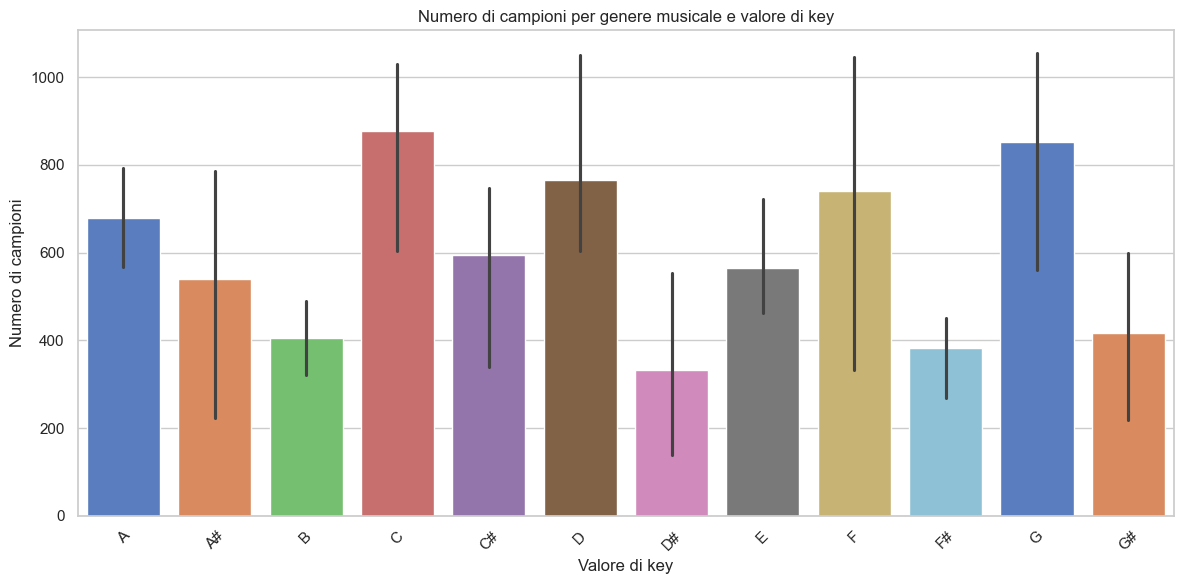

In [84]:
grouped = top3_df.groupby(['genre', 'key']).size().unstack(fill_value=0)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, palette="muted")
plt.xlabel('Valore di key')
plt.ylabel('Numero di campioni')
plt.title('Numero di campioni per genere musicale e valore di key')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Handling of time_signature

In [85]:
print(top3_df['time_signature'].unique())
#It is very likely that the entry of 1/4 is a data entry error because it is equivalent to 4/4.
top3_df.loc[:, 'time_signature'] = top3_df['time_signature'].replace(['1/4'], '4/4')
print("Tracks with a 0/4 time signature: %s" % len(top3_df[top3_df['time_signature'] == '0/4']))
top3_df = top3_df[top3_df['time_signature'] != '0/4']  # Remove the rows with '0/4' from the 'time_signature' column.

['4/4' '3/4' '1/4' '5/4']
Tracks with a 0/4 time signature: 0


### Genre distribution

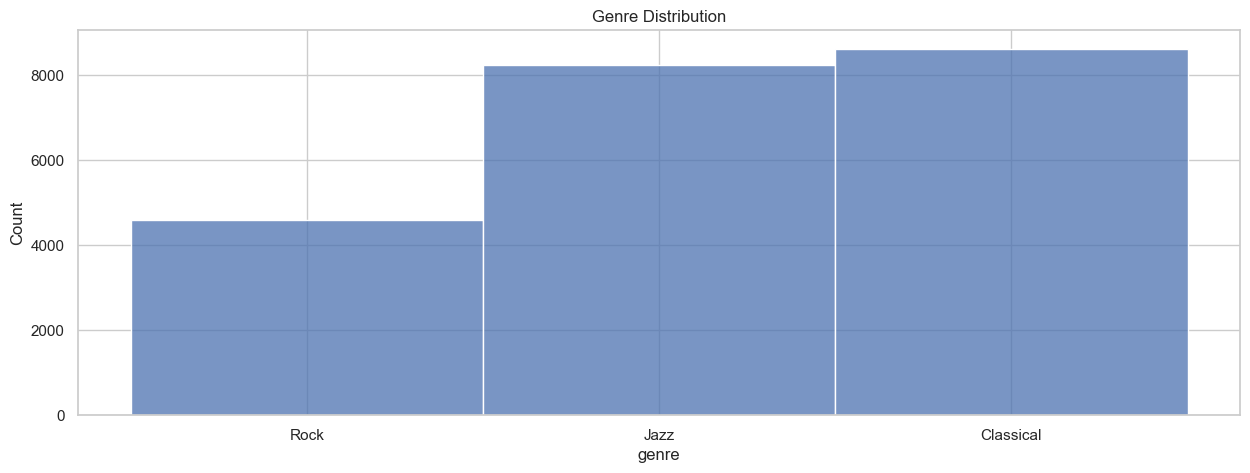

In [86]:
plt.figure(figsize=(15, 5))
sns.histplot(top3_df['genre']).set_title('Genre Distribution')
plt.show()

In [87]:
# We notice that the dataset is unbalanced.

## Conversion of categorical values

In [88]:
#We use labels because they are ordinal categorical values
time_signature_mapping = {'3/4': 0,'4/4':1 ,'5/4': 2}
top3_encoded_df=top3_df
top3_encoded_df['time_signature'] = top3_encoded_df['time_signature'].map(time_signature_mapping)
mode_mapping = {'Major': 1,'Minor':0}
top3_encoded_df['mode'] = top3_encoded_df['mode'].map(mode_mapping)
notes_ordered = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
key_mapping = {note: index for index, note in enumerate(notes_ordered)}
top3_encoded_df['key'] = top3_encoded_df['key'].map(key_mapping)
print(top3_df.head())

            genre  popularity  acousticness  danceability  energy  instrumentalness  key  liveness  loudness  mode  speechiness    tempo  time_signature  valence
166420       Rock          75         0.584         0.394   0.918          0.332000    1    0.3090    -3.743     1       0.0709  115.646               1    0.479
148655       Jazz          47         0.879         0.509   0.238          0.001510    8    0.1150   -13.779     1       0.0311  113.998               1    0.177
104433  Classical          25         0.912         0.551   0.262          0.722000    4    0.0846   -21.402     0       0.0369  112.474               0    0.737
179886       Jazz          41         0.410         0.674   0.697          0.000406    1    0.0415    -7.622     1       0.0412   85.530               1    0.902
147560       Jazz          49         0.625         0.607   0.682          0.000010    0    0.0489    -9.085     1       0.0327  177.367               1    0.950


## Normalization

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

top3_encoded_df['loudness'] *= -1

# Splitting labels from features
t = top3_encoded_df['genre']
X = top3_encoded_df.drop(['genre'], axis=1)

# Splitting the dataset in train and test
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

#Merging X_train and X_test, t_train and t_test into a single DataFrame
X_combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

t_train = pd.DataFrame(t_train).reset_index(drop=True)
t_test = pd.DataFrame(t_test).reset_index(drop=True)

X_train['genre'] = t_train
X_test['genre'] = t_test

df_with_labels = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

#final dataframe
print("\ncombined_df_with_labels:")
print(df_with_labels)



combined_df_with_labels:
       popularity  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness     tempo  time_signature   valence      genre
0       -2.355693      1.045850     -0.521500 -0.951933          0.987515 -1.186521 -0.352549  1.190776  0.756561    -0.230510 -0.892205        0.309359 -1.099035  Classical
1        0.456909      0.747097     -0.314374 -0.596522         -0.977757 -1.186521 -0.278199  0.335022  0.756561    -0.128940  0.257100        0.309359  0.362408  Classical
2        1.894461      0.371080     -0.542212  1.197139         -0.976418 -1.472699  3.979983 -0.738688  0.756561     0.032573  2.062865        0.309359  2.056085       Rock
3       -0.418123      0.852691     -1.562306 -0.882179         -0.892475 -0.900343 -0.420139  0.823082 -1.321770    -0.345401 -0.332166        0.309359 -1.265815  Classical
4       -0.543128      0.999492     -1.365536 -1.242240          0.580816 -0.041807 -0.748627  1.216672 

## Further data exploration

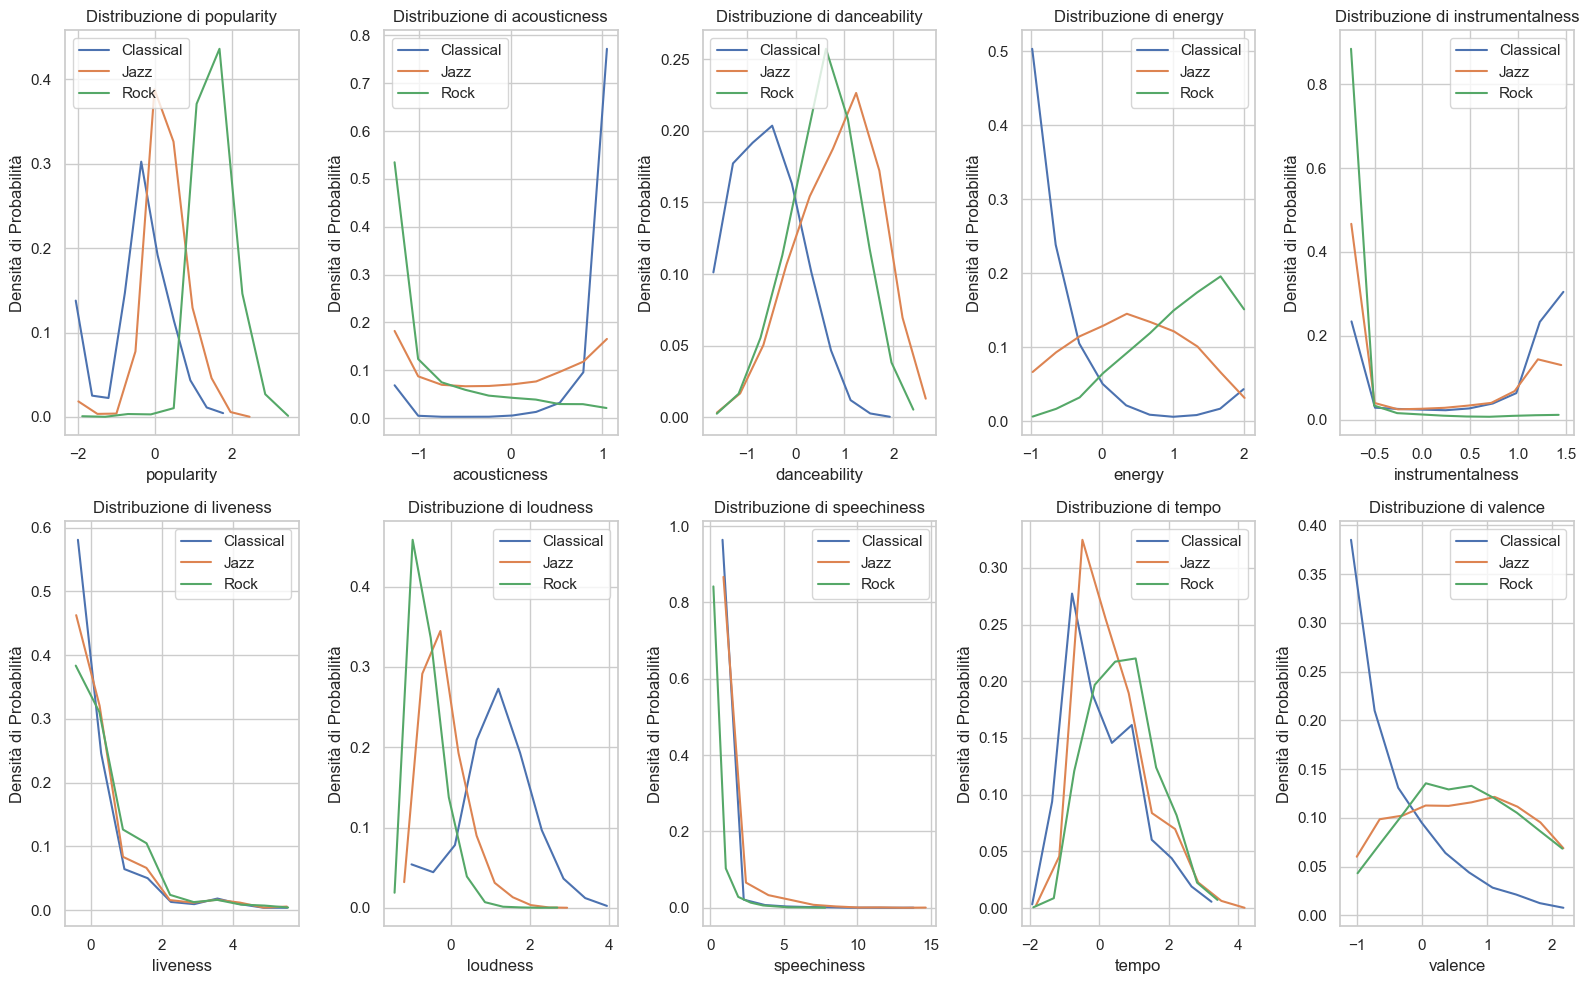

In [90]:
num_rows = 2
num_cols = (len(features) + 1) // 2
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, start=1):
    plt.subplot(num_rows, num_cols, i)

    for genre, data in df_with_labels.groupby('genre'):
        counts, bin_edges = np.histogram(data[feature], bins=10, density=True)
        pdf = counts / sum(counts)

        plt.plot(bin_edges[1:], pdf, label=genre)

    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densità di Probabilità')
    plt.legend()

plt.tight_layout()
plt.show()

In [91]:
#We might consider dropping tempo, speechiness, liveness, and instrumentalness since their distributions are largely
#overlapping and thus not sufficiently discriminating.

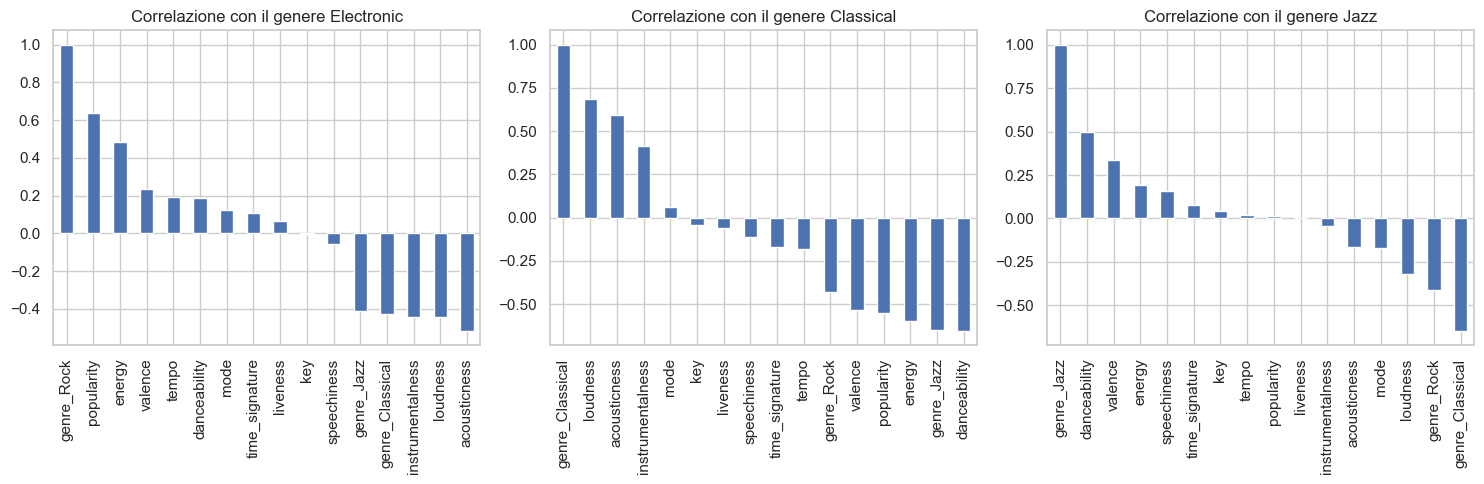

In [92]:
#Let's try to understand which features better explain the genres.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
X_dummies=pd.get_dummies(df_with_labels)
X_dummies.corr()['genre_Rock'].sort_values(ascending=False).plot(kind='bar', ax=axs[0])
axs[0].set_title('Correlazione con il genere Electronic')
X_dummies.corr()['genre_Classical'].sort_values(ascending=False).plot(kind='bar', ax=axs[1])
axs[1].set_title('Correlazione con il genere Classical')
X_dummies.corr()['genre_Jazz'].sort_values(ascending=False).plot(kind='bar', ax=axs[2])
axs[2].set_title('Correlazione con il genere Jazz')
plt.tight_layout()
plt.show()

In [93]:
#The result of the previous graph is confirmed by this graph. We also notice that key doesn't explain well enough the genre.

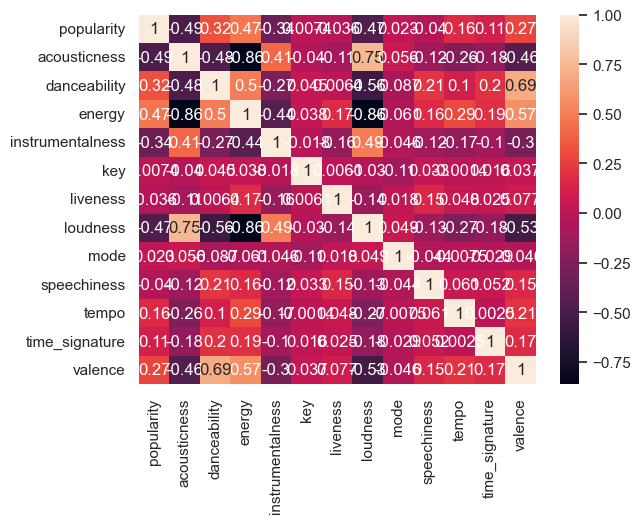

In [94]:
#Analysis of the correlation between features
corr_matrix = df_with_labels.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [95]:
#We notice that energy is highly correlated with acousticness, and we might consider dropping one of them.

In [96]:
df_with_labels=df_with_labels.reset_index(drop=True).drop(columns=['key','instrumentalness','speechiness','liveness','tempo','time_signature'], axis=1)


#top5_encoded_df.drop('energy', axis=1)


# Outlier management

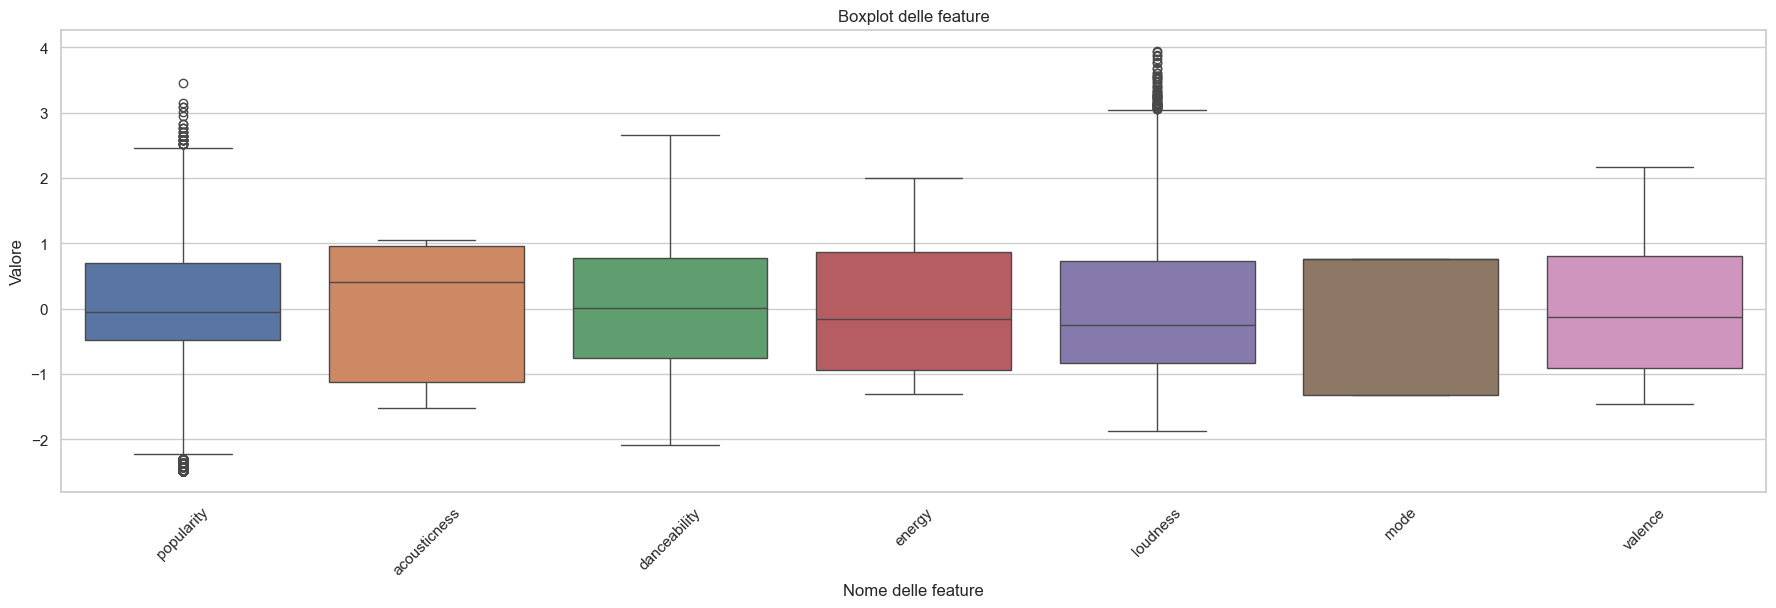

In [97]:
#grafico box per controllare outlier
plt.figure(figsize=(22, 6))
ax = sns.boxplot(data=df_with_labels.drop(['genre'], axis=1).values)
ax.set_xticks(range(len(df_with_labels.drop(['genre'], axis=1).columns)))  # Imposta esplicitamente i tick
ax.set_xticklabels(df_with_labels.drop(['genre'], axis=1).columns, rotation=45)
plt.xlabel('Nome delle feature')  # Aggiungi un'etichetta all'asse x
plt.ylabel('Valore')  # Aggiungi un'etichetta all'asse y
plt.title('Boxplot delle feature')  # Aggiungi un titolo al grafico
plt.show()

#print(X_train.head())
#mi concentro sulle feature 5,6,8 che sono quelle con outlier (tempo, liveness, loudaness e  speechiness)

In [98]:
#Splitting into train and test to remove outliers only from train
t = df_with_labels['genre']
X = df_with_labels.drop(['genre'], axis=1)

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

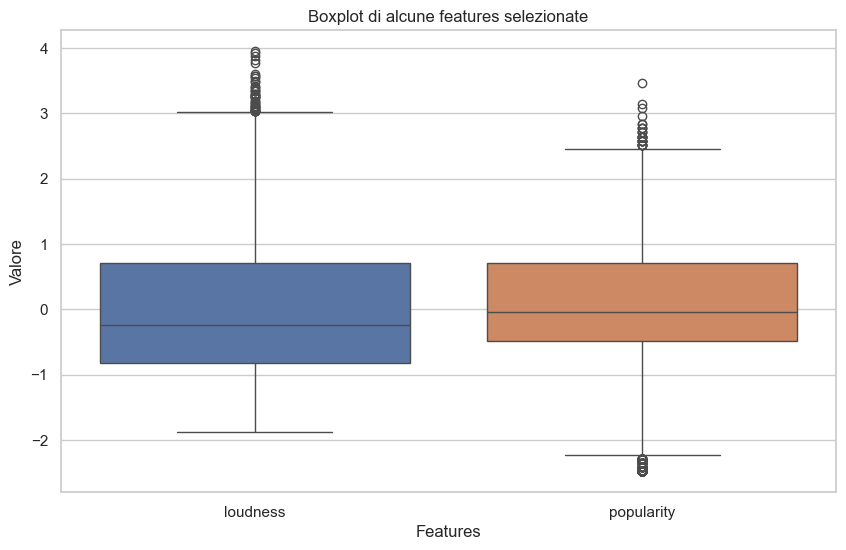

In [99]:
selected_columns = X_train[[ 'loudness','popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()

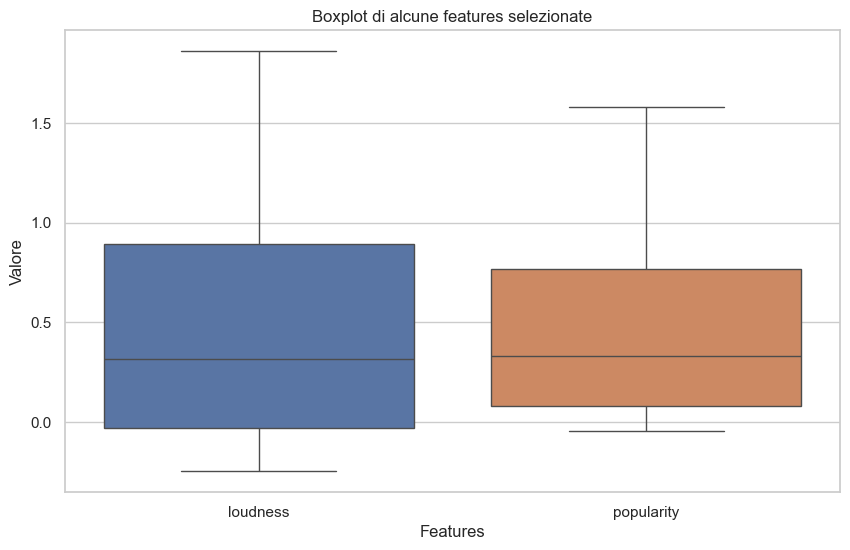

In [100]:
# Removing outliers from X_train and corresponding records from y_train
quantiles = X_train[['loudness','popularity']].quantile([0.5, 0.95])
lower_quantile = quantiles.iloc[0]
upper_quantile = quantiles.iloc[1]

X_train = X_train[(X_train['loudness'] >= lower_quantile['loudness']) & (X_train['loudness'] <= upper_quantile['loudness'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

X_train = X_train[(X_train['popularity'] >= lower_quantile['popularity']) & (X_train['popularity'] <= upper_quantile['popularity'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

# Graph without outliers
selected_columns = X_train[['loudness', 'popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()


## VIF

In [101]:
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)


        Feature   VIF
3        energy  7.25
4      loudness  3.53
1  acousticness  3.35
6       valence  2.37
2  danceability  2.06
0    popularity  1.47
5          mode  1.01


In [102]:
# we notice we could drop energy

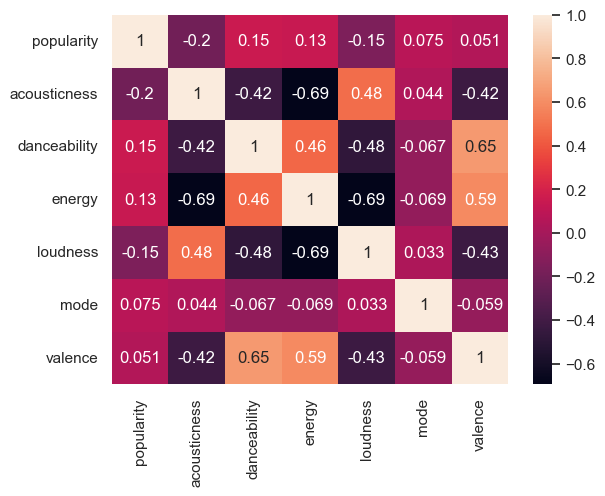

In [103]:
#Let's check if the correlation matrix gives us the same result
corr_matrix = X_train.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()
# we can definetly drop energy

In [104]:
X_train.drop('energy', axis=1, inplace=True)
X_test.drop('energy', axis=1, inplace=True)
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)

        Feature   VIF
3      loudness  2.22
5       valence  2.09
1  acousticness  2.08
2  danceability  1.98
0    popularity  1.27
4          mode  1.01


# logistic regression

In [105]:
hyper_param = [
    {
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs','newton-cg', 'sag', 'saga'],
        'max_iter': [100, 1000, 2500]
    }
]

# Model creation and training using grid search
clf = GridSearchCV(linear_model.LogisticRegression(multi_class='multinomial'), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_weighted')
best_clf = clf.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clf.best_params_)
print("F1 score on the train set: ", clf.best_score_)

# Training the best model on the complete training data
best_model = linear_model.LogisticRegression(**clf.best_params_)
best_model.fit(X_train, t_train)

# Prediction on the test set
t_hat_test = best_model.predict(X_test)

# Calculation of evaluation metrics on the test set
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))
print(classification_report(t_test, t_hat_test))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Tuned hyperparameters (best parameters):  {'C': np.float64(11.288378916846883), 'max_iter': 100, 'solver': 'newton-cg'}
F1 score on the train set:  0.8017507371604108
Accuracy score on the test set:  0.8638832841843862
F1 score on the test set:  0.8645971633033971
              precision    recall  f1-score   support

   Classical       0.94      0.82      0.88      2607
        Jazz       0.80      0.88      0.84      2447
        Rock       0.86      0.91      0.88      1389

    accuracy                           0.86      6443
   macro avg       0.87      0.87      0.87      6443
weighted avg       0.87      0.86      0.86      6443



c:\Users\rugge\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Confusion matrix

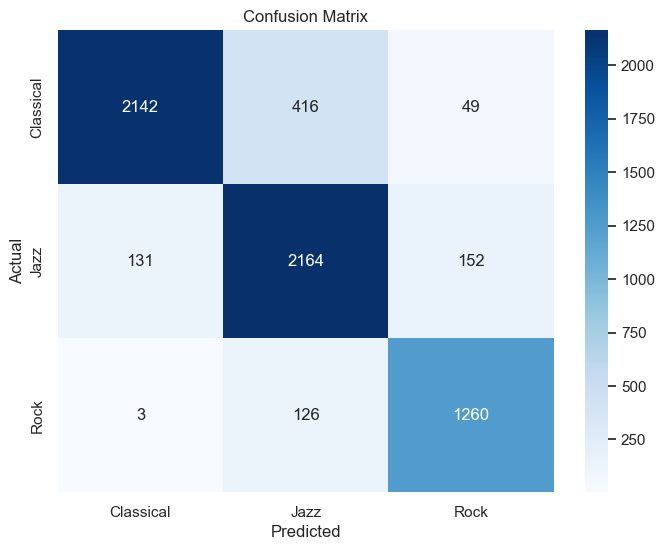

In [106]:
conf_matrix = confusion_matrix(t_test, t_hat_test)

labels = ['Classical', 'Jazz','Rock']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [107]:
hyper_param = [
    {
        'n_neighbors': [3, 7,9,11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
]

clfKNN = GridSearchCV(KNeighborsClassifier(), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise",scoring='f1_macro')
best_clf = clfKNN.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clfKNN.best_params_)
print("Accuracy:", clfKNN.best_score_)

t_hat_test = clfKNN.predict(X_test)
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))


# Training the best model on the complete training data
model = KNeighborsClassifier(**clfKNN.best_params_)
model.fit(X_train, t_train)

# Prediction on the test set
t_pred = model.predict(X_test)

# Calculation of evaluation metrics on the test set
print(classification_report(t_test, t_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tuned hyperparameters (best parameters):  {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.7184509427486485
Accuracy score on the test set:  0.8148378084743132
F1 score on the test set:  0.817027108683779
              precision    recall  f1-score   support

   Classical       0.95      0.75      0.84      2607
        Jazz       0.70      0.91      0.79      2447
        Rock       0.89      0.76      0.82      1389

    accuracy                           0.81      6443
   macro avg       0.85      0.81      0.82      6443
weighted avg       0.84      0.81      0.82      6443



## ROC-AUC

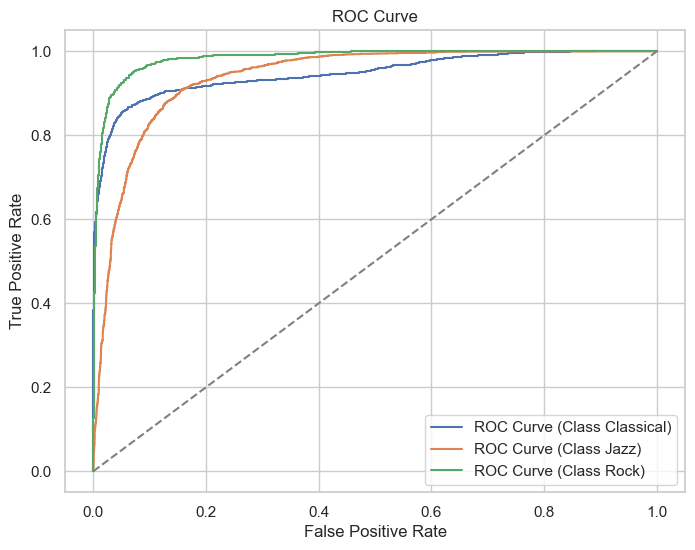

In [108]:
# Calculate the class probabilities for the test set
probs = clf.predict_proba(X_test)

# Calculate the ROC-AUC for each class
roc_auc = roc_auc_score(t_test, probs, multi_class='ovr')  # 'ovr' for multiclass problems

#Calculate and plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(t_test == labels[i], probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC Curve (Class {labels[i]})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network

In [109]:
print(t_train)

7396          Jazz
11033         Jazz
5823     Classical
15013    Classical
5230          Jazz
           ...    
18284         Jazz
18818    Classical
9723     Classical
17724    Classical
16734    Classical
Name: genre, Length: 2161, dtype: object


In [110]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
t_train = encoder.fit_transform(t_train)  # Converti le stringhe in numeri
t_test = encoder.transform(t_test) 

hyper_param_mlp = {
    'hidden_layer_sizes': [(100,100), (100, 150), (150, 150)],
    'activation': [ 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True, False],
    'max_iter': [500]
}

clfMLP = GridSearchCV(MLPClassifier(), param_grid=hyper_param_mlp, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_mlp = clfMLP.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clfMLP.best_params_)
print("Accuracy:", clfMLP.best_score_)

best_mlp_model = MLPClassifier(**clfMLP.best_params_)
best_mlp_model.fit(X_train, t_train)

t_hat_test_mlp = best_mlp_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_hat_test_mlp, average='weighted'))

print(classification_report(t_test, t_hat_test_mlp))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuned hyperparameters (best parameters):  {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (150, 150), 'max_iter': 500, 'solver': 'adam'}
Accuracy: 0.7568745259915761
F1 score on the test set:  0.8322854350352562
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      2607
           1       0.72      0.92      0.81      2447
           2       0.91      0.82      0.86      1389

    accuracy                           0.83      6443
   macro avg       0.86      0.83      0.84      6443
weighted avg       0.85      0.83      0.83      6443



# SVM

In [111]:
hyper_param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

clf_svm = GridSearchCV(SVC(), param_grid=hyper_param_svm, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_svm = clf_svm.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clf_svm.best_params_)
print("Accuracy:", clf_svm.best_score_)

best_svm_model = SVC(**clf_svm.best_params_)
best_svm_model.fit(X_train, t_train)

t_pred_svm = best_svm_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_pred_svm, average='weighted'))
print(classification_report(t_test, t_pred_svm))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned hyperparameters (best parameters):  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7548048458637383
F1 score on the test set:  0.8617943242683769
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2607
           1       0.80      0.88      0.84      2447
           2       0.85      0.91      0.88      1389

    accuracy                           0.86      6443
   macro avg       0.86      0.87      0.86      6443
weighted avg       0.87      0.86      0.86      6443

